In [0]:
import pandas as pd
import numpy as np
import datetime as dt

In [0]:
%pip install optree
%pip install keras tensorflow
import keras

Note: you may need to restart the kernel using %restart_python or dbutils.library.restartPython() to use updated packages.
Note: you may need to restart the kernel using %restart_python or dbutils.library.restartPython() to use updated packages.


2025-07-31 01:43:39.358699: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2025-07-31 01:43:39.434954: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2025-07-31 01:43:39.457209: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1753926219.481584    2953 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1753926219.490276    2953 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1753926219.523787    2953 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linkin

In [0]:
from keras.models import Sequential
from keras.layers import Dense
from keras.optimizers import Adam
from keras.layers import Masking

In [0]:
data = pd.read_csv("/Workspace/Users/n01657739@humber.ca/test_model_electricity_load_ahmed/datasets/Book3.csv")
display(data)

Date,Hour,DryBulb,DewPnt,SYSLoad,NumDate
2004-01-01 00:00:00.0,1,37,25,12230,732000.0
2004-01-01 00:00:00.0,2,37,25,11534,732000.0
2004-01-01 00:00:00.0,3,39,24,11038,732000.0
2004-01-01 00:00:00.0,4,38,22,10777,732000.0
2004-01-01 00:00:00.0,5,37,20,10764,732000.0
2004-01-01 00:00:00.0,6,36,19,11032,732000.0
2004-01-01 00:00:00.0,7,35,20,11508,732000.0
2004-01-01 00:00:00.0,8,35,20,11806,732000.0
2004-01-01 00:00:00.0,9,35,21,12457,732000.0
2004-01-01 00:00:00.0,10,37,21,13214,732000.0


In [0]:
%pip install xlrd
hdata = pd.read_excel("/Workspace/Users/n01657739@humber.ca/test_model_electricity_load_ahmed/datasets/Holidays.xls")
display(hdata)

Note: you may need to restart the kernel using %restart_python or dbutils.library.restartPython() to use updated packages.


Date,Holiday
2004-01-01T00:00:00Z,New Year's Day
2004-01-19T00:00:00Z,Martin Luther King Day
2004-02-16T00:00:00Z,President's Day
2004-05-31T00:00:00Z,Memorial Day
2004-07-05T00:00:00Z,Independence Day
2004-09-06T00:00:00Z,Labor Day
2004-11-25T00:00:00Z,Thanksgiving
2004-11-26T00:00:00Z,Day After Thanksgiving
2004-12-24T00:00:00Z,Christmas
2004-12-31T00:00:00Z,New Year's Day


In [0]:
holidays=hdata.Date
holidays.head()

0   2004-01-01
1   2004-01-19
2   2004-02-16
3   2004-05-31
4   2004-07-05
Name: Date, dtype: datetime64[ns]

In [0]:

#Convert dates to datetime data type
data['Date']=pd.to_datetime(data['Date'])
data.dtypes


Date       datetime64[ns]
Hour                int64
DryBulb             int64
DewPnt              int64
SYSLoad             int64
NumDate           float64
dtype: object

In [0]:
#get the day of the week for each date in the data
dayofweek=data.Date.dt.weekday
dayofweek.head()

0    3
1    3
2    3
3    3
4    3
Name: Date, dtype: int32

In [0]:
isworkday = np.in1d(dayofweek,[0,1,2,3,4]) & ~np.in1d(data['Date'],holidays)
isworkday[22]

/root/.ipykernel/2953/command-2315841472297563-1689000366:1: DeprecationWarning: `in1d` is deprecated. Use `np.isin` instead.
  isworkday = np.in1d(dayofweek,[0,1,2,3,4]) & ~np.in1d(data['Date'],holidays)


np.False_

In [0]:
prevdaysamehour=np.hstack(((np.ones(24)*-1),(data['SYSLoad'][0:-24])))
prevdaysamehour[0]

np.float64(-1.0)

In [0]:
prevweeksamehour=np.hstack(((np.ones(168)*-1),(data['SYSLoad'][0:-168])))
prevweeksamehour.shape

(52608,)

In [0]:
import scipy
import scipy.signal
#By using the lfilter method get the previous 24 hour averrage temperature
prev24houravg = scipy.signal.lfilter(np.ones(24) / 24, 1, data['SYSLoad'])
prev24houravg.shape

(52608,)

In [0]:
#Put all the input data together into a single matrix
X = np.vstack((data['DryBulb'],data['DewPnt'],data['Hour'],dayofweek))
X.shape
display(pd.DataFrame(X.T).head(5))

0,1,2,3
37,25,1,3
37,25,2,3
39,24,3,3
38,22,4,3
37,20,5,3


In [0]:
#Put all the input data together into a single matrix
X = np.vstack((data['DryBulb'],data['DewPnt'],data['Hour'],dayofweek,isworkday,prevweeksamehour,prevdaysamehour,prev24houravg))
X.shape
display(pd.DataFrame(X.T).head(5))

0,1,2,3,4,5,6,7
37.0,25.0,1.0,3.0,0.0,-1.0,-1.0,509.5833333333333
37.0,25.0,2.0,3.0,0.0,-1.0,-1.0,990.1666666666666
39.0,24.0,3.0,3.0,0.0,-1.0,-1.0,1450.0833333333333
38.0,22.0,4.0,3.0,0.0,-1.0,-1.0,1899.125
37.0,20.0,5.0,3.0,0.0,-1.0,-1.0,2347.625


In [0]:
X=np.transpose(X)
X.shape

(52608, 8)

In [0]:
numcols=X.shape[1]


In [0]:
#Take out the first 168 indexes because they have null values
X=X[168:,:]
data=data[168:]
print(X.shape)
print(data.shape)

(52440, 8)
(52440, 6)


In [0]:
#Find the training index that will be used to split the data into train and test
trainInd = data.Date < dt.datetime(2008, 1, 1)
trainX = X[trainInd,:]
trainX.shape

(34896, 8)

In [0]:
#assign the training outputs
trainY=data.SYSLoad[trainInd]
trainY=trainY.to_numpy()
trainY = trainY.reshape((trainY.shape[0], 1))
trainY.shape

(34896, 1)

In [0]:
#split the range for the validation data
validX=X[34896:43680]
validX.shape
validX[-1]

array([ 8.0000000e+00, -5.0000000e+00,  2.4000000e+01,  2.0000000e+00,
        1.0000000e+00,  1.3253000e+04,  1.3827000e+04,  1.6115375e+04])

In [0]:
validY=data.SYSLoad[34896:43680]
validY=validY.to_numpy()
validY = validY.reshape((validY.shape[0], 1))
validY[-1]

array([15438])

In [0]:
testInd = data.Date>= dt.datetime(2009, 1, 1)
testX=X[testInd,:]
print(testX)

[[ 7.00000000e+00 -6.00000000e+00  1.00000000e+00 ...  1.21240000e+04
   1.28040000e+04  1.61936250e+04]
 [ 6.00000000e+00 -7.00000000e+00  2.00000000e+00 ...  1.13450000e+04
   1.21980000e+04  1.62724583e+04]
 [ 6.00000000e+00 -8.00000000e+00  3.00000000e+00 ...  1.08240000e+04
   1.19230000e+04  1.63455417e+04]
 ...
 [ 2.70000000e+01  2.50000000e+01  2.20000000e+01 ...  1.54490000e+04
   1.73440000e+04  1.58159167e+04]
 [ 2.70000000e+01  2.40000000e+01  2.30000000e+01 ...  1.47590000e+04
   1.59130000e+04  1.57670000e+04]
 [ 2.70000000e+01  2.40000000e+01  2.40000000e+01 ...  1.38030000e+04
   1.44660000e+04  1.57456250e+04]]


In [0]:
testY=data.SYSLoad[testInd]
testY=testY.to_numpy()
testY = testY.reshape((testY.shape[0], 1))

In [0]:
from keras.optimizers import SGD

In [0]:

from sklearn.svm import SVR
from sklearn.metrics import r2_score

# Define the validation period
validation_start_date = dt.datetime(2009, 12, 31) - dt.timedelta(days=2*365)

# Split the data into training and validation sets
trainInd = data.Date < validation_start_date
validationInd = data.Date >= validation_start_date

trainX = X[trainInd, :]
trainY = data.SYSLoad[trainInd].to_numpy().reshape(-1, 1)
validationX = X[validationInd, :]
validationY = data.SYSLoad[validationInd].to_numpy().reshape(-1, 1)

# Train the SVM model
svm = SVR(kernel='rbf')
svm.fit(trainX, trainY.ravel())

# Predict and evaluate on the validation set
predY_svm = svm.predict(validationX)
accuracy_svm = r2_score(validationY, predY_svm)
accuracy_svm

0.6564807263176702

In [0]:
import time
start_time = time.time()

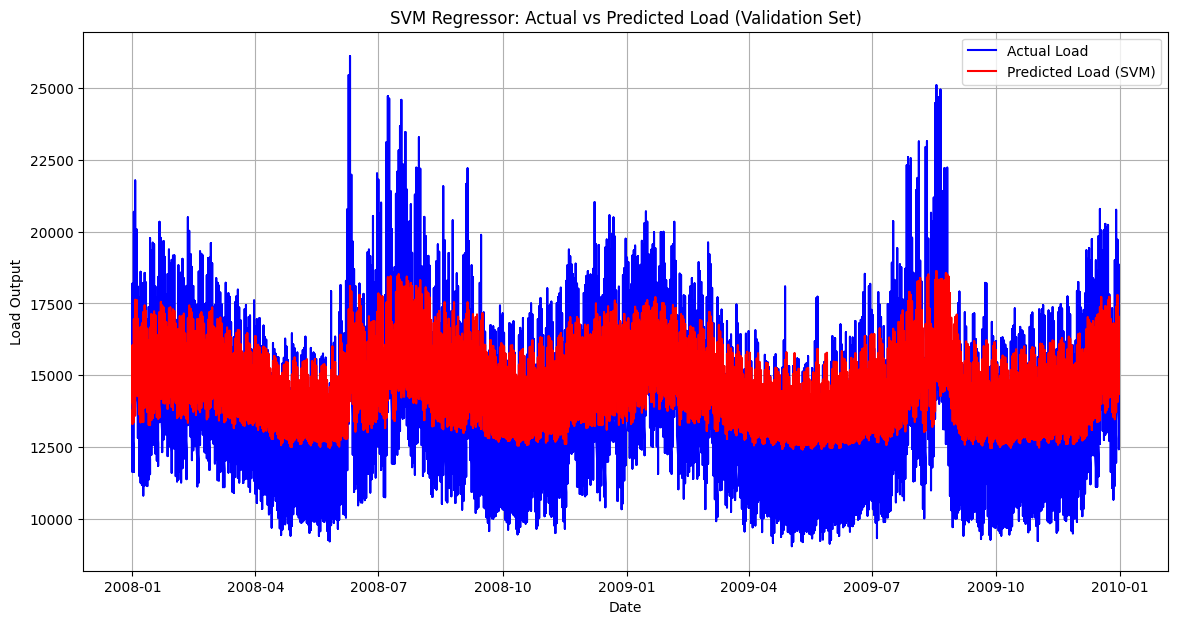

In [0]:
import matplotlib.pyplot as plt

# Extract dates for the validation set
validation_dates = data.Date[validationInd]

# Plot actual vs predicted values for the validation set
plt.figure(figsize=(14, 7))
plt.plot(validation_dates, validationY, label='Actual Load', color='blue')
plt.plot(validation_dates, predY_svm, label='Predicted Load (SVM)', color='red', linestyle='-')

plt.xlabel('Date')
plt.ylabel('Load Output')
plt.title('SVM Regressor: Actual vs Predicted Load (Validation Set)')
plt.legend()
plt.grid(True)
plt.show()

In [0]:
accuracy = 100 - mape
print(f"Model Accuracy: {accuracy:.2f}%")

---------------------------------------------------------------------------
NameError                                 Traceback (most recent call last)
File <command-2315841472297589>, line 1
----> 1 accuracy = 100 - mape
      2 print(f"Model Accuracy: {accuracy:.2f}%")

NameError: name 'mape' is not defined